# Imports, setting up device and seeds

In [1]:
from all_imports import *

In [2]:
SET_ALL_SEEDS = True

if SET_ALL_SEEDS:
    import os
    import random

    def set_all_seeds(seed):
        os.environ["PL_GLOBAL_SEED"] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    set_all_seeds(42)
else:
    torch.manual_seed(42)

In [3]:
VERSION = 'm'   # either 'm' or 'f'

In [4]:
# torch.cuda.set_device(1)
if VERSION == 'f':
    device = torch.device('cuda')
else:
    device = torch.device('mps')

device = torch.device('cpu')

# Constants

In [5]:
VALIDATION_PERCENTAGE = 0.10

if VERSION == 'f':
    TRAIN_PATH = "/kaggle/input/traffic/trafic_32"
else:
    TRAIN_PATH = "./trafic_32"

# Loading data

In [6]:
%%time
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 256

trainFolder = torchvision.datasets.ImageFolder(root=TRAIN_PATH,
                                               transform=transform)

n_val = int(np.floor(VALIDATION_PERCENTAGE * len(trainFolder)))
n_train = len(trainFolder) - n_val
train_ds, val_ds = random_split(trainFolder, [n_train, n_val])

trainloader = DataLoader(train_ds, batch_size=batch_size, drop_last=True, shuffle=True)
validloader = DataLoader(val_ds , batch_size=batch_size, drop_last=True, shuffle=True)

CPU times: user 212 ms, sys: 598 ms, total: 811 ms
Wall time: 1.27 s


In [7]:
# takes images from valid dataset
def get_train_images(num):
    return torch.stack([val_ds[i][0] for i in range(10,10+num)], dim=0)

In [8]:
trainFolder

Dataset ImageFolder
    Number of datapoints: 39209
    Root location: ./trafic_32
    StandardTransform
Transform: Compose(
               ToTensor()
           )

# Model - VAE

In [9]:
from VAE import VAE, vae_loss_function

USED_MODEL = 'vae'

if USED_MODEL == 'vae':
    net = VAE(latent_dim=256, hidden_dim=1024, x_dim=32*32*3).to(device)
else:
    raise Exception('Invalid model used')

# Training loop

## VAE training loop

In [10]:
if USED_MODEL == 'vae':
    # criterion = nn.MSELoss(reduction="sum")
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

    %%time
    num_epochs = 3
    for n in range(num_epochs):
        losses_epoch = []
        for x, _ in iter(trainloader):
            x = x.to(device)
            out, means, log_var = net(x)
            out = out.cpu()
            x = x.cpu()
    #         out = x.view (x.shape[0],3,32,32)
    #         print("OUT SHAPE: ", out.shape)
    #         print("X SHAPE: ", x.shape)
            if USED_MODEL == 'vae':
                loss = vae_loss_function(x, out, means, log_var)
            else:
                raise Exception('Invalid model used')
            losses_epoch.append(loss.item())
            loss.backward()               
            optimizer.step()             
            optimizer.zero_grad()  
            
        L1_list = []
        for x, _ in iter(validloader):
            x  = x.to(device)
            out, _, _ = net(x)
            L1_list.append(torch.mean(torch.abs(out-x)).item())
            
        print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
        scheduler.step()

UsageError: Line magic function `%%time` not found.


# Saving model to file

In [11]:
# saving model to file
from datetime import datetime

def get_current_datetime_formatted():
    return f'{datetime.now()}'.replace('-', '_').replace(' ', '_').replace(':', '_')[:-4]
state_dict = net.state_dict()
current_datetime_formatted = get_current_datetime_formatted()
torch.save(state_dict, f"generated_models/{USED_MODEL}_{current_datetime_formatted}.tar")

# Reconstructions

In [12]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

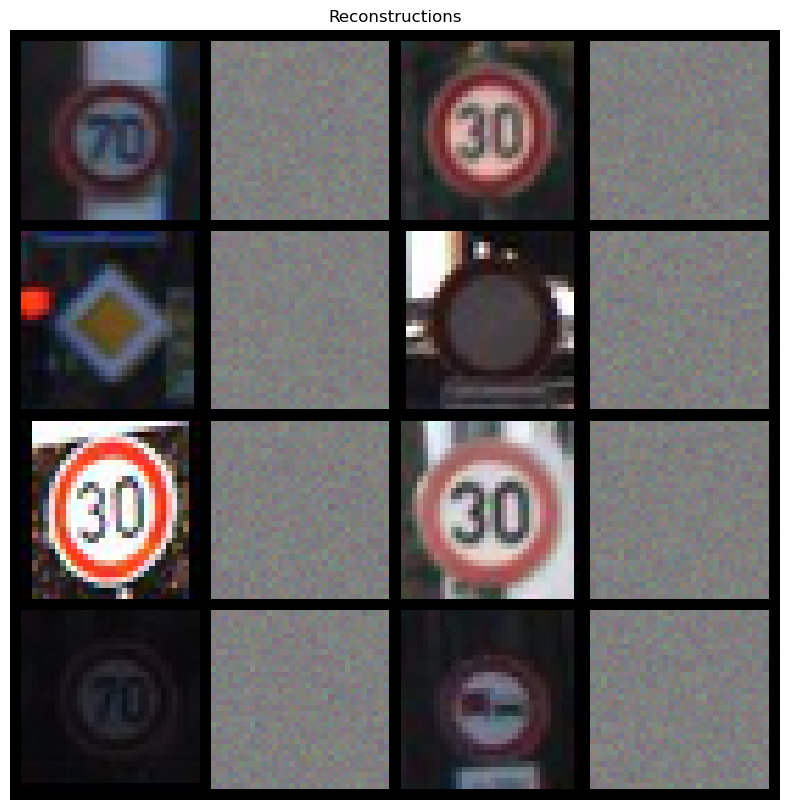

In [13]:
input_imgs = get_train_images(8)
visualize_reconstructions(net, input_imgs, device)

# Generating new images

In [14]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()
    
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

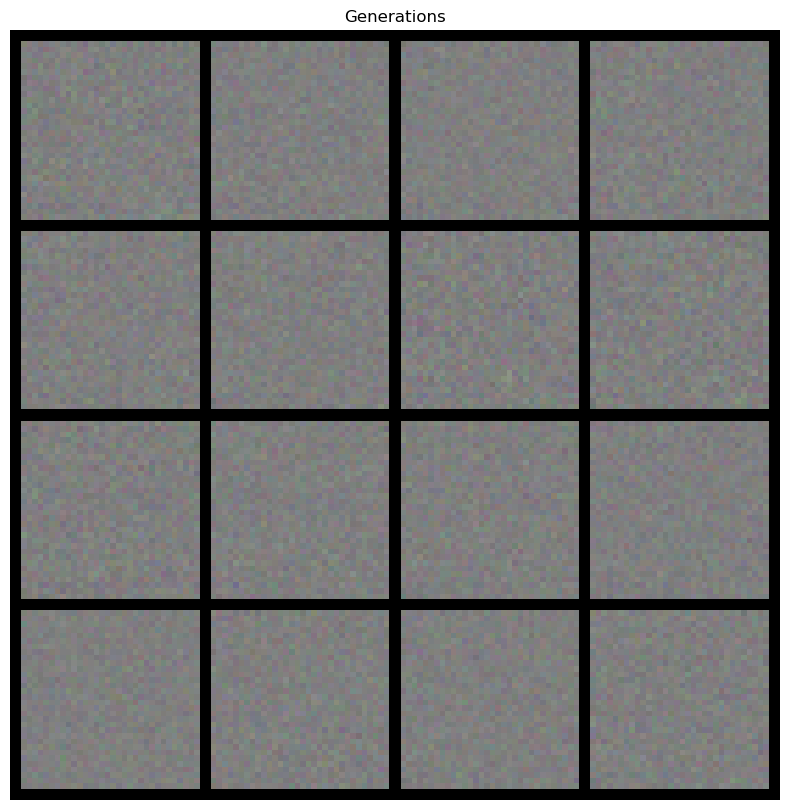

In [15]:
generate_images(net, 16, device)

# Hidden layer VAE

In [16]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    labels = []
    for imgs, label in data_loader:
        with torch.no_grad():
            mean, var_log = model.encoder(imgs.to(device))
        img_list.append(imgs)
        embed_list.append(mean)
        labels.append(label)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0), torch.cat(labels, dim=0))


In [17]:
import umap
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [18]:
umap_object = umap.UMAP(metric="cosine", n_neighbors=100)
train_img_embeds = embed_imgs(net, trainloader)
test_img_embeds = embed_imgs(net, validloader)
train_embedded = umap_object.fit_transform(train_img_embeds[1][:5000].cpu())

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [19]:
def plot_latent(train_embedded, train_img_embeds, n_data=5000):
    data = pd.DataFrame(train_embedded[:n_data])
    data["label"] = train_img_embeds[2][:n_data].cpu().numpy()
    examples = []
    examples_locations = []
    for i in np.random.randint(0,n_data,40):
        examples.append(train_img_embeds[0][i].squeeze(0).cpu().numpy())
        examples_locations.append(data.iloc[i])
    fig, ax = plt.subplots(figsize=(12, 10))
    # ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
    sns.scatterplot(
        x=0, y=1,
        hue="label",
        palette=sns.color_palette("hls", 43),
        data=data,
        legend="full",
        alpha=0.1
    )
    for location, example in zip(examples_locations, examples):
        x, y = location[0], location[1]
        label = int(location["label"])
        print(example.shape)
        ab = AnnotationBbox(OffsetImage(example,cmap=plt.cm.gray_r, zoom=1), (x, y), frameon=True,
                            bboxprops=dict(facecolor=sns.color_palette("hls", 43)[label], boxstyle="round"))
        ax.add_artist(ab)
    plt.show()

In [20]:
# plot_latent(train_embedded, train_img_embeds)

<AxesSubplot: xlabel='0', ylabel='1'>

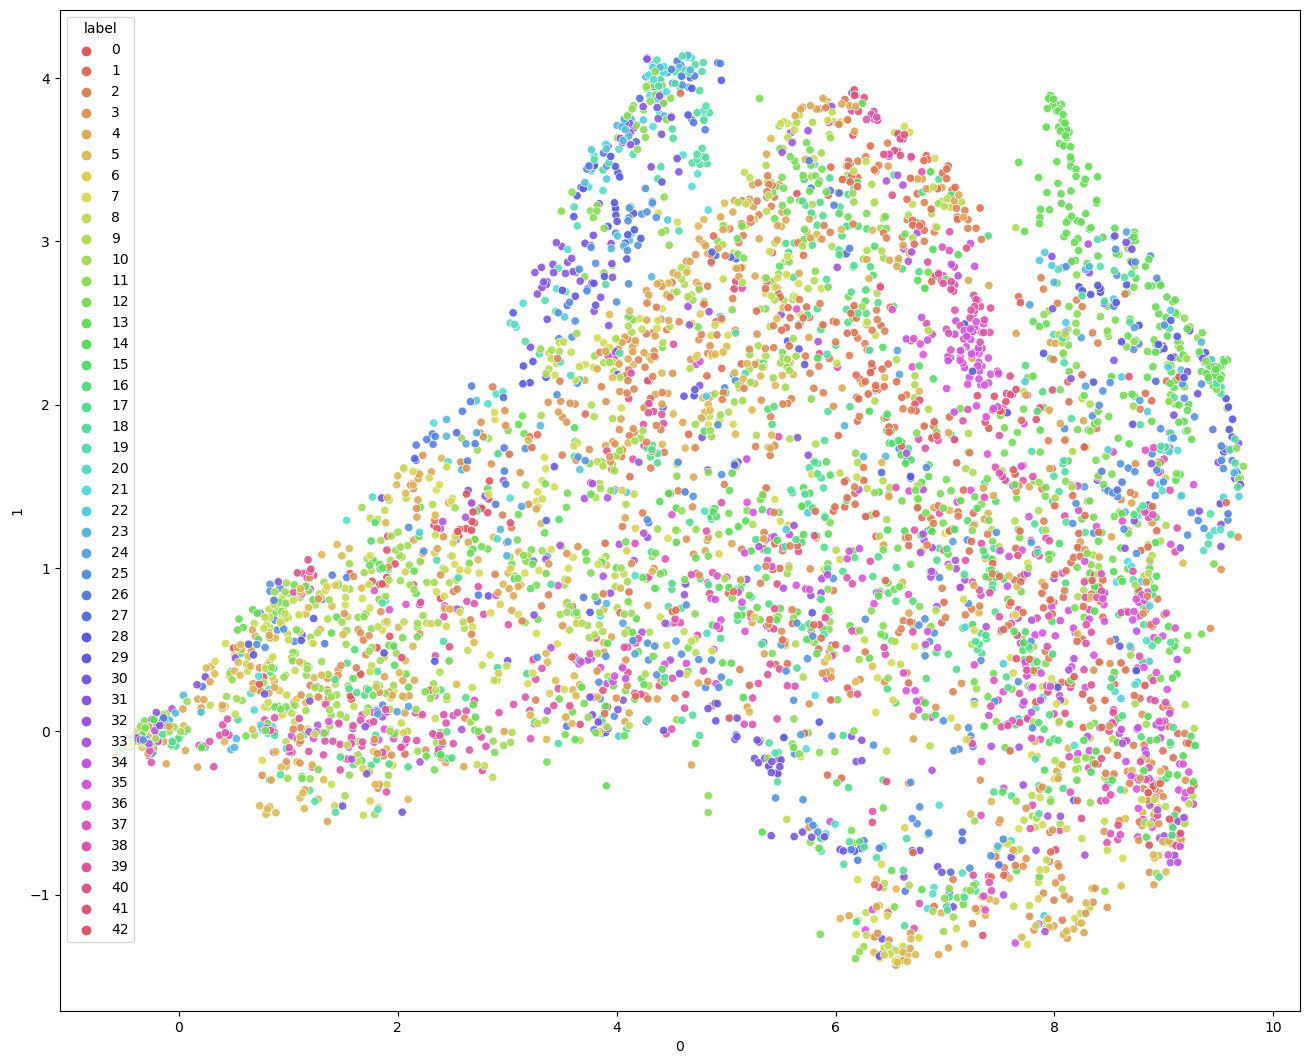

In [21]:
data = pd.DataFrame(train_embedded[:5000])
data["label"] = train_img_embeds[2][:5000].cpu().numpy()
fig, ax = plt.subplots(figsize=(16, 13))
# ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", 43),
    data=data,
    legend="full",
    alpha=0.9
)

# Evaluation - Frechet Inception distance

In [22]:
import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [23]:
class Evaluator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Evaluator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 50)
        self.fc_out  = nn.Linear(50, 10)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def get_features(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        return x
    

    def forward(self, x):
        x = self.get_features(x)
        x = self.fc_out(x)
        return x

evaluator = Evaluator(32*32*3, 256).to(device)

In [24]:
orig_data = [x[0] for x in list(val_ds)[:1000]]
orig_data = torch.stack(orig_data)

In [25]:
with torch.no_grad():
    latent_dim=256
    fixed_noise = torch.randn(1000, latent_dim, device=device)
    generations_vae = net.decoder(fixed_noise)
    
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_vae = evaluator.get_features(generations_vae.to(device)).cpu()

In [26]:
orig_data_2 = [x[0] for x in list(val_ds)[-1000:]]
orig_data_2 = torch.stack(orig_data_2)
with torch.no_grad():
    dist_orig_data_2 = evaluator.get_features(orig_data_2.to(device)).cpu()

In [27]:
for name, obj in zip(['orig','vae'],[dist_orig_data_2.numpy(), dist_vae.numpy()]):
    print(f"FD {name}: {calculate_frechet_distance(dist_orig_data.numpy(),obj)}")

FD orig: 0.00169752114108207
FD vae: 0.16632001452851522


# Saving generated images to file

In [28]:
torch.save(generations_vae.cpu().detach(), f"generated_images/poniedzialek_Lopatto_Sakowski{get_current_datetime_formatted()}.pt")